# Ultimate Challenge Take Home

## 1: EDA

Start by loading dataframe and visual inspection.

In [61]:
#load json as dataframe
import pandas as pd

login_fname = 'logins.json'

df = pd.read_json(login_fname)

In [62]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


This is a simple dataframe with one column. Time to check, shape, dtype and if any null values. We will also check peiod of data by looking at min and max datetimes.

In [63]:
print(df.info())
print(df.min())
print(df.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
login_time   1970-01-01 20:12:16
dtype: datetime64[ns]
login_time   1970-04-13 18:57:38
dtype: datetime64[ns]


We expect the data to be highly cyclical with hourly patterns, daily patterns etc. We will start the wrangling as per the instructions and create a simple custom function to round the time stamp to its 15 minute (quarterly) bin. This is done with rounddown meaning that the actual time for every given label is in the 15 minute period following the labe;. For example: 20:15 indicates actual time falls in interval 20:15 to 20:30. A custom function allows us to have a clear understanding of edge cases.

In [64]:
import datetime

def generate_quarterly_datetime(date1):
    'discretizes time of datetime in 15 minute bins rounding down'
    year1 = date1.year
    month1 = date1.month
    day1 = date1.day
    hour1 = date1.hour
    min1 = (date1.minute // 15)*15
    
    answer = datetime.datetime(year1, month1, day1,
                              hour1, min1)
    
    return answer

df['date_quart'] = df.login_time.apply(generate_quarterly_datetime).values

Resample to get new df consisting of discretized timestamps as index and count as column

In [65]:
df_resampled = pd.DataFrame(df.groupby('date_quart').size())
df_resampled.columns = ['count']

Add useful labels to further explore cyclicality across days of weeks, months, etc. and inspect

In [66]:
df_resampled['day_of_week'] =  df_resampled.index.day_name().values
df_resampled['is_weekday'] = df_resampled.day_of_week.apply(lambda x: 'no' if x in ['Saturday', 'Sunday'] else 'yes')
df_resampled['month'] = df_resampled.index.month.values 

df_resampled.head()

,count,day_of_week,is_weekday,month
date_quart,,,,
1970-01-01 20:00:00,2,Thursday,yes,1
1970-01-01 20:15:00,6,Thursday,yes,1
1970-01-01 20:30:00,9,Thursday,yes,1
1970-01-01 20:45:00,7,Thursday,yes,1
1970-01-01 21:00:00,1,Thursday,yes,1


When working with aggregate functions across categories, we will want to work with averages to make sure data is normalized and that we can compare categories with eachother. The default setup is to report average in number of logins per 15 minute periods in the given category. In  order for these averages to be comparable, we will need to chekc if there are gaps in the data and one category has a materially different divisor. 

The below code checks for these gaps:

In [67]:
index1 = df_resampled.index[:-1]
index2 = df_resampled.index[1:]

diff = index2 - index1
diff.value_counts(normalize=True)

0 days 00:15:00    0.967804
0 days 00:30:00    0.023348
0 days 00:45:00    0.006823
0 days 01:00:00    0.001812
0 days 01:30:00    0.000107
0 days 01:15:00    0.000107
Name: date_quart, dtype: float64

No gaps in the data would mean 100% of values fall at 15 minutes. While this is not the case, 97% is pretty good and with no extreme outliers like we can be fairly confident with the default averaging process.

### 1.1 Macro View (High Level Cycle)

We'll start simple and very macro by looking at average logins per month, weekday type and weekday.

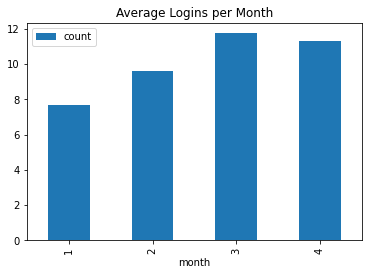

In [68]:
#Monthly
df_monthly_mean = df_resampled[['month', 'count']].groupby('month').mean()
df_monthly_mean.plot(kind='bar', title='Average Logins per Month');


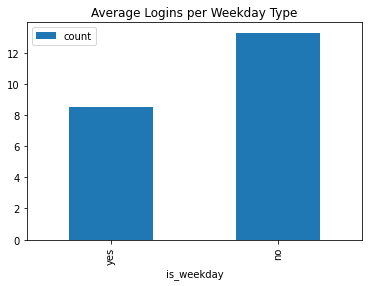

In [69]:
#Weekday or Weekend
df_is_weekday_mean = df_resampled[['is_weekday', 'count']].groupby('is_weekday').mean()
df_is_weekday_mean.loc[['yes', 'no']].plot(kind='bar', title='Average Logins per Weekday Type');

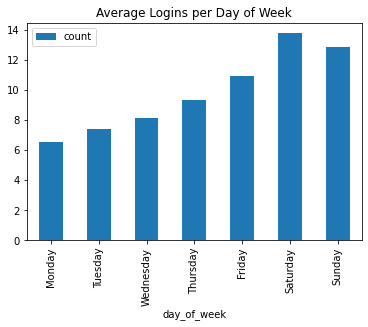

In [70]:
#Day of Week
df_day_of_week_mean = df_resampled[['day_of_week', 'count']].groupby('day_of_week').mean();
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']
df_day_of_week_mean.loc[weekdays_order].plot(kind='bar', title='Average Logins per Day of Week');

__The key overvations are:__
- Login growth evident from Jan to March but petering off in April. We would want to investigate the reasons behind this. In particualr, whether it is seasonal with then end of Winter or is indicative of something more sinister for the business
- Average logins are almost 50% higher on weekends than weekdays
- There as an evident increase in logins as we progress through the week from Monday with a peak on Saturdays. Sunday is still the second highest

### 1.2 Granular View (Daily Cycle)

We will now look more granularly at the daily cycle across various categories starting with the split between weekends and weekdays.

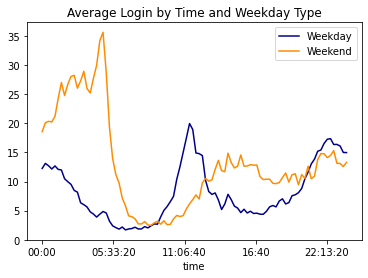

In [71]:
import matplotlib.pyplot as plt

#Group by is weekday 
df_resampled['time'] = df_resampled.index.time
df_sub = df_resampled[['time','is_weekday','count']]
df_sub = df_sub.groupby(['time','is_weekday']).mean().unstack()
#select and label
weekday = pd.Series(df_sub.loc[:,('count', 'yes')], name='Weekday')
weekend = pd.Series(df_sub.loc[:,('count', 'no')], name='Weekend')
#plot
weekday.plot(legend=True, color='darkblue');
weekend.plot(legend=True, color='darkorange');
plt.title('Average Login by Time and Weekday Type');


We will now look at day of the week for weekdays

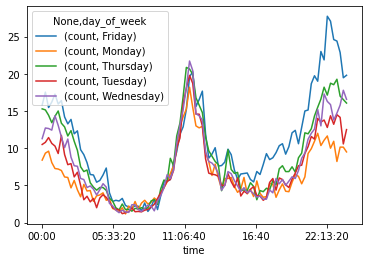

In [72]:
#group by day of week (midweek only) and plot
df_sub1 = df_resampled[['time','day_of_week','count']][~df_resampled.day_of_week.isin(['Saturday','Sunday'])]
df_sub1 = df_sub1.groupby(['time','day_of_week']).mean().unstack(level=1)
df_sub1.plot();

and for weekends seperately to keep the graphs cleaner

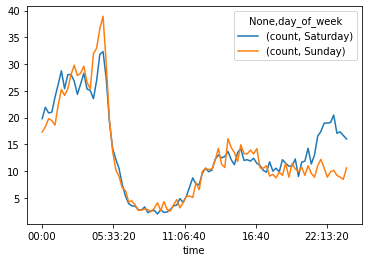

In [73]:
#group by day of week (weekends only) and plot
df_sub2 = df_resampled[['time','day_of_week','count']][df_resampled.day_of_week.isin(['Saturday','Sunday'])]
df_sub2 = df_sub2.groupby(['time','day_of_week']).mean().unstack(level=1)
df_sub2.plot();

__The key observations are:__

- Weekdays have a clear daily cycle with two peaks around 11:00 and 22:00 repsectively. The first peak is higher for all days except for Fridays. This makes inutuitive sense as Friday's are likely to be "going out after work night" with extra demand for a taxi home at the later peak.
- Not surprisingly, we see more variance in the evening peak than the morning peak between week days.
- The weekend pattern is quite different with a large peak around 05:30 and a much smaller one beginning around 2pm. There is also a plateau with fairly consistent logins from 2pm towards midnight for Sundays. Saturday has a third peak around 23:00 which again probably represent coming home trips from the weekend night out.  
- We notice the weekend scale is larger than weekdays- inline with the earlier observation of higher average demand on weekends

### 1.3 Summary of Key Observations

- __Peak demand is 11:00 and 22:00 on weekdays__
- __Peak demand is 0530 (much larger) and 2pm on Weekends__
- __Demand on Weekends is higher and more consistent from the afternoon into the evening__ 
- __Demand gradually increases during the week form Monday to Friday__
- __Demand growth was positive Jan to March but experienced a dip in April (spring effect?)__

__PS:__ We have focused average demand but we could also explore demand variability over these same time periods by looking at the variance or standard deviation of the statistics if the business considered this an important consideration for this high level overview.


## 2. Experimental Design

The goal of the reimbursement is to encourage drivers to serve both towns across the bridge according only to demand. My approach would be to design a simple test that quickly answer the question of whether the change is successful at the same time as having more granular underlying information that can assist the business with implementation.

The approach would be as follows:

__1. Key metric is the percentage of drivers who serve both cities over a specified period.__ Knowing the cyclicality in the data, we need to be careful to choose the before and after periods so that they match as closely as possible in terms of demand. We also need to be aware of other potenitial externalities. for example: rain, snow, concerts, sporting events etc. could skew the comparison. 

__2. I would choose a consecutive two week period to tun the experiemnt over with the first week having no subsidy and the second having the subsidy.__ The periods would run Monday to Monday and I would be chose such that there were no planned major events like concerts or sports games. Monday to Monday ensure we capture the cyclality of demand and is long enough to, hopefully, dampen the effects of any unforeseen externalities like weather (although this will need ot be monitored).  

__3. With the metric and the time period in place, it would be a simple matter of a standard one-tailed hypothesis test using a 95% confidence level__
- Hypothesis statement: If a subsidy is introduced then the percentage of drivers serving both towns over a one week (Monday to Monday) period will increase.
- Null Hypothesis to be tested: D%_subsidy - D%_no_subsidy <= 0 where D% represents the % of drivers who serve both towns from Monday to Monday.   

__4. This design would also have the opportunity to drill down in the data to answer or raise some pertient implementation questions.__ The data could be reconfigured over smaller time periods. For example, we could look at the data over day of the week, weekday type and intraday times to work out whether we want to implement a blanket subsidy or only over specified days or times. Additionally, the aim of the subsidy is to incentivise _driver_ behavior and data collected at a driver level could be used to explore the profile of the drivers most willing to take advantage of the subsidy. This could assist with the recruitment of more productive drivers.  

## 3. Prediction of User Retention

### 3.1.1 Data Cleaning 

In [74]:
#load dataset and inspect
import pandas as pd

df_ret = pd.read_json('ultimate_data_challenge.json')

df_ret    #view top/tail as better chance to also nans

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [75]:
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We notice null values in 3 columns. They are relatively insignificant for avg_rating_driver and phone but account for 16% of data for avg_rating_of_driver. Given these numbers, we are comfortable using imputation (by hand) to fill these null values for continuous variables.

We first want to check how these null values appear:

In [76]:
#check how null values appear
print(df_ret.avg_rating_of_driver.sort_values().iloc[-1],
      type(df_ret.avg_rating_of_driver.sort_values().iloc[-1]))
print(df_ret.avg_rating_by_driver.sort_values().iloc[-1],
      type(df_ret.avg_rating_by_driver.sort_values().iloc[-1]))
print(df_ret.phone.sort_values().iloc[-1],
      type(df_ret.phone.sort_values().iloc[-1]))

nan <class 'numpy.float64'>
nan <class 'numpy.float64'>
None <class 'NoneType'>


The continuous variables appear as np.nan and can be replaced with fillna():

In [77]:
#replace nan with mean for continuous variables
imp_avg_rating_of_driver = df_ret.avg_rating_of_driver.mean()
imp_avg_rating_by_driver  = df_ret.avg_rating_by_driver.mean()

df_ret.avg_rating_of_driver = df_ret.avg_rating_of_driver.fillna(imp_avg_rating_of_driver).values
df_ret.avg_rating_by_driver = df_ret.avg_rating_by_driver.fillna(imp_avg_rating_by_driver).values

We will assign phone categories randomly in the same proportion as currently in the sample

In [78]:
#sampling replacement for nan categotical variables
import random

phone_cats = df_ret.phone.dropna().tolist()
df_ret.phone = df_ret.phone.apply(lambda x: x if x!= None else 
                        random.sample(phone_cats,1)[0]).values



We will also take the opportunity to convert appropriate columns from strings to datetime.date

In [79]:
#convert dates to datetime
df_ret['last_trip_date'] = pd.to_datetime(df_ret['last_trip_date']).dt.date.values
df_ret['signup_date'] = pd.to_datetime(df_ret['signup_date']).dt.date.values

Since the current date is left out (quite intentionally I am sure ;) ) of the question description, I will use the max of the last ride date for the purpose of calculating the "active" status. Any customer who has taken a ride in the rpeceding 30 days of this date is active, otherwise inactive:

In [80]:
#calc cutoff date and add retained column to df
from datetime import timedelta
max_date = df_ret['last_trip_date'].max()
cut_off = max_date - timedelta(days=30)

df_ret['retained'] = df_ret['last_trip_date'].apply(lambda x: True if x>=cut_off else False)


Let's check we have repaired null values

In [81]:
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
 12  retained                50000 non-null  bool   
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 4.3+ MB


### 3.1.2 Date Exploration

We will start by answering the explicit question posed on user retention:

In [82]:
df_ret['retained'].value_counts(normalize=True)

False    0.62392
True     0.37608
Name: retained, dtype: float64

Only 38% of users were retained suggesting large scope for improvement.

We will let the question at hand guide our data exploration and we will compare the proportion of active vs inactive users in each variable group. While it might be tempting to do the oppopsite- look at how many inactive users have a certain property- this could be misleading as it doesn't account for the imbalance across each variable. For example of 90% of all users have a certain property, then we can guess that a very high percentage of inactive users have this property too and gives us very little real information. Of course, looking at each graph seperately ignores any colinearity that will need more sophisticated methods to tease out at a later point. Potentially during features selection.

After these caveats, we will plot this ratio across values of relevant variables and put the overall inactive ratio as the 'by chance' reference on the graphs:

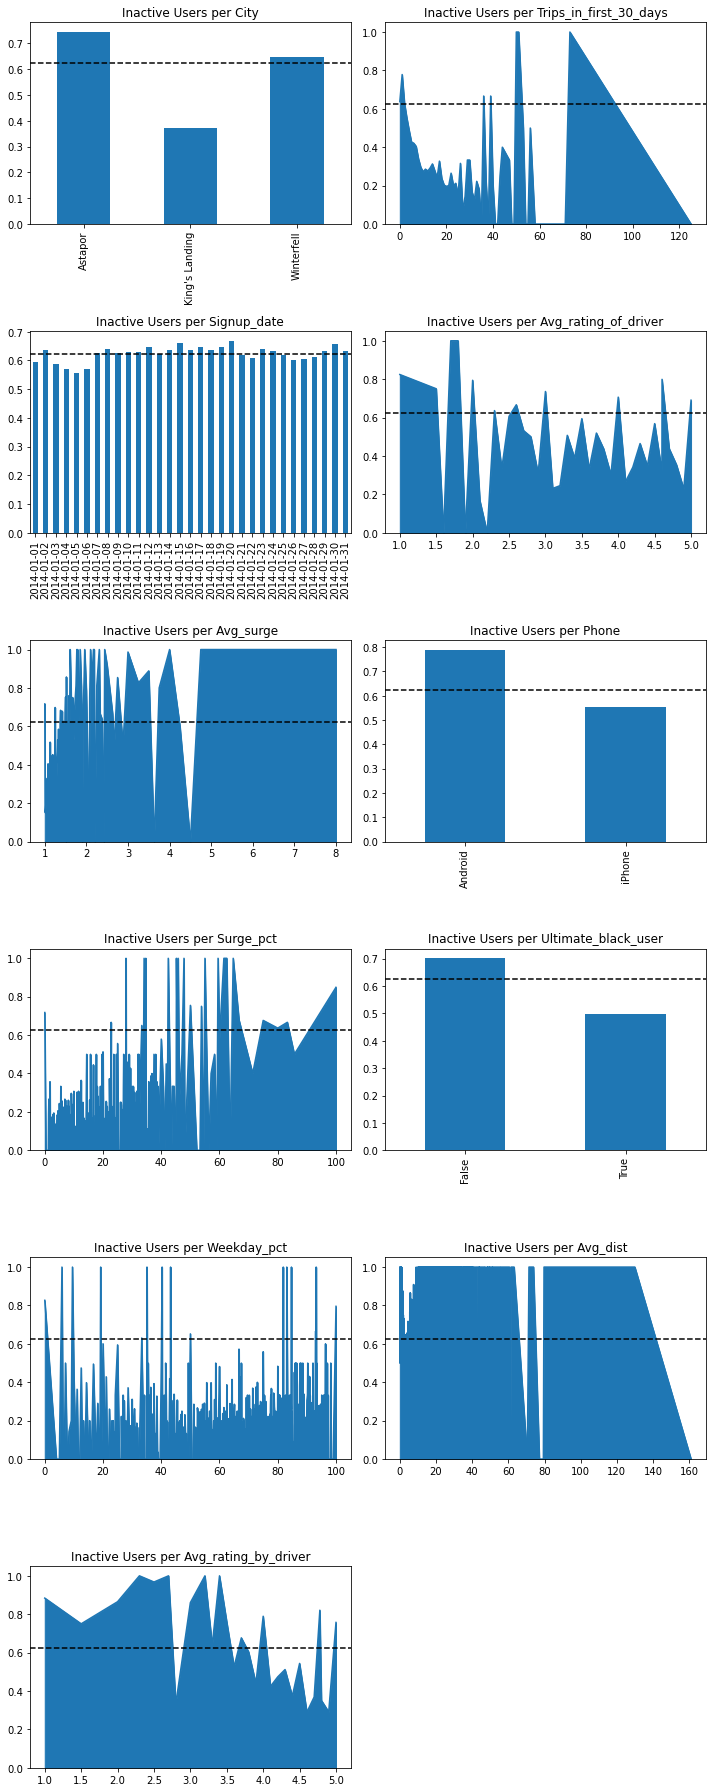

In [83]:
import matplotlib.pyplot as plt

#variables to be plotted
vars_list = df_ret.columns.tolist()
vars_list.remove('retained')
vars_list.remove('last_trip_date')

#plot in subplot
plt.figure(figsize=(10,25))
plot_number = 1
for j in range(11):
    var = vars_list[j]
    
    if df_ret[var].dtype == 'O':
        kind = 'bar'
    elif df_ret[var].dtype == 'bool':
        kind='bar'
    else:
        kind = 'area'
        
    df = df_ret.groupby([var,'retained']).size().unstack()
    df.index.name=''
    df = df.div(df.sum(axis=1), axis=0).loc[:,False]
    
    ax = plt.subplot(6, 2, plot_number)
    df.plot(kind=kind, title = 'Inactive Users per '+ var.capitalize())
    plt.axhline(0.624, ls='--', color='black')
    plot_number = plot_number + 1
    
plt.tight_layout()
    

We would expect graphs with high variation across values and away form the reference baseline to have some relationship to inactivity. In this respect, the following are the most interesting:

 - __city:__ King's landing appears to be particularly active and Astapor particularly inactive
 - __trips_in_first_30_days:__ There is a lot of non-linearity here and it appears numbers on the extremes (and potenitally in the belly) suggest elevated inactivity.
 - __phone:__ iphone users more likely to be acyive and Android less likely
 - __surge_pct:__ Low surge percent looks to suggest higher chance of activity
 - __ultimate_black_user:__ None users more likely to be inactive
 - __avg_rating_of_driver:__ Higher the rating, the more likely user to be active

### 3.2 Predictive Model

We will start by defining the features set and getting it ready for the model. This means conversion of categorical variables to dummies and dates to days relative to max_date

In [84]:
#Wrangle features- dummy variables and dates to days
df_features = df_ret.drop(['retained', 'last_trip_date', 'phone', 'city','signup_date'], axis=1)
df_features['ultimate_black_user'] = (df_features['ultimate_black_user']*1).values
phone_dummies = pd.get_dummies(df_ret.phone)
city_dummies = pd.get_dummies(df_ret.city)
signup_in_days = (max_date - df_ret.signup_date).dt.days
df_features = pd.concat([df_features, phone_dummies, city_dummies, signup_in_days], axis=1)


In [85]:
#inspect
df_features

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Android,iPhone,Astapor,King's Landing,Winterfell,signup_date
0,4,4.700000,1.10,15.4,1,46.2,3.67,5.0,0,1,0,1,0,157
1,0,5.000000,1.00,0.0,0,50.0,8.26,5.0,1,0,1,0,0,153
2,3,4.300000,1.00,0.0,0,100.0,0.77,5.0,0,1,1,0,0,176
3,9,4.600000,1.14,20.0,1,80.0,2.36,4.9,0,1,0,1,0,172
4,14,4.400000,1.19,11.8,0,82.4,3.13,4.9,1,0,0,0,1,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,0,100.0,5.63,4.2,0,1,0,1,0,157
49996,1,4.601559,1.00,0.0,0,0.0,0.00,4.0,0,1,1,0,0,158
49997,0,5.000000,1.00,0.0,1,100.0,3.86,5.0,1,0,0,0,1,151
49998,2,3.000000,1.00,0.0,0,100.0,4.58,3.5,0,1,1,0,0,168


We will now define the target variable such that 1 represents not retained (note flip)

In [86]:
#define target
df_target = (~df_ret.retained*1)

__Define holdout and training set__

In [87]:
from sklearn.model_selection import ShuffleSplit

#generate random index for sets
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None)
train_index, holdout_index = list(rs.split(df_target.values))[0]
#define training set
df_features_train = df_features.iloc[train_index]
df_target_train = df_target.iloc[train_index]
#define holdout set
df_features_holdout = df_features.iloc[holdout_index]
df_target_holdout = df_target.iloc[holdout_index]

__Select model before getting to feature selection and fine tuning__ 

Let's see which model out of logistic regression, random forest or gradient boosting gives the best defualt scores using all features

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

scoring = 'f1'
X_train = df_features_train.values
y_train = df_target_train.values

#models to be tested
clf_list = [LogisticRegression(solver='newton-cg',random_state=42),
            RandomForestClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42)] 
clf_names = ['LogReg', 'RandForrest', 'GradBoost']

#fit and score models in loop
scores_clf_mean = []
scores_clf_std = []
for clf in clf_list:        
    scores = cross_val_score(clf, X_train, y_train, scoring= scoring, cv=5)
    scores_clf_mean.append(scores.mean())
    scores_clf_std.append(2*scores.std())

    #format and display results
results = pd.DataFrame({scoring: scores_clf_mean, '2*std':scores_clf_std},
                      index=clf_names)
results.sort_values(scoring, ascending=False)

    


,f1,2*std
GradBoost,0.832906,0.006650
RandForrest,0.817936,0.009913
LogReg,0.789406,0.010235


Gradient Boosting gives the best accuracy and we will now do hyperparamter tuning on this model before looking at feature selection.

__Tree Based Param Tuning for Grad Boost__

Find best number of estimators for defualt learning rate of 0.1 and some rule of thumb starting values for other params

In [89]:
#CV Gridsearch for n estimators
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                            min_samples_leaf=50,max_depth=8,max_features='sqrt',
                                                               subsample=0.8,random_state=42), 
param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

#optimal paramters and score
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.8355442252989631)

__Tree Specific Param Tuning for Grad Boost__

Find best max depth and min samples split with a learning rate of 0.1 and nestimators of 80

In [90]:
#CV grid search for mas depth and samples min split
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, 
                                                               max_features='sqrt', subsample=0.8, 
                                                               random_state=42), 
param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

#optimal paramters and score
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 13, 'min_samples_split': 600}, 0.8366996666841434)

Alot of work for little return- the optimal params only deliver an improvement of 0.2% for the score. Nonetheless we will use these params going forward. 

__Feature Selection__

__Feature ranking using all features__



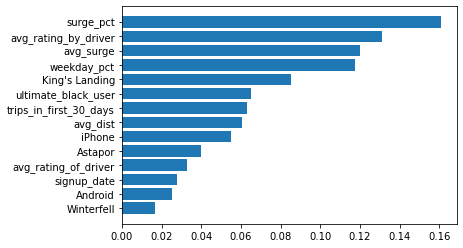

In [93]:
import numpy as np

#instantiate model
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', 
                                 max_depth=13, min_samples_split=600, subsample=0.8, random_state=42)
#fit model
clf.fit(X_train, y_train)

#feature importance and ranking
feature_importance = clf.feature_importances_
idx = np.argsort(feature_importance)

feature_importance = feature_importance[idx]
feature_names = np.array(df_features.columns)[idx]

#plot feature importance in descending order
plt.barh(feature_names, feature_importance);

__Next we will iteratively drop the lowest ranking feature and calcuate the f1 metric on the test set__

In [92]:
from sklearn.metrics import f1_score

#define list of variables to iteratively dropped
drop_list=['signup_date', 'avg_surge', 'avg_rating_of_driver', 
          'avg_dist' , 'trips_in_first_30_days', ['iPhone', 'Android'],
         'ultimate_black_user', ['Winterfell', 'Astapor', "King's Landing"],
          'weekday_pct', 'surge_pct']

#split non-holdout set into train_test sets
rs1 = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None)
train_index1, test_index1 = list(rs.split(df_target_train.values))[0]

df_features_train1 = df_features_train.iloc[train_index1]
df_target_train1 = df_target_train.iloc[train_index1]

df_features_test1 = df_features_train.iloc[test_index1]
df_target_test1 = df_target_train.iloc[test_index1]

y_train1 = df_target_train1.values
y_test1 = df_target_test1.values

#initialize feature dfs
df_X_train1 = df_features_train1
df_X_test1 = df_features_test1

for var in drop_list:
    #drop features in trianing and test sets
    df_X_train1 = df_X_train1.drop(var, axis=1)
    X_train1 = df_X_train1.values
    
    df_X_test1 = df_X_test1 .drop(var, axis=1)
    X_test1 = df_X_test1.values
    
    #instantiate model
    clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', 
                                 max_depth=13, min_samples_split=600, subsample=0.8, random_state=42)
    #fit model
    clf.fit(X_train1, y_train1)
    
    #predict on test set and score
    y_pred = clf.predict(X_test1)
    f1 = f1_score(y_test1, y_pred)
    
    print('drop = ', var, ' : ',"n=%d,f1: %.2f%%" % (X_train1.shape[1], f1*100.0))
    

drop =  signup_date  :  n=13,f1: 83.28%
drop =  avg_surge  :  n=12,f1: 83.60%
drop =  avg_rating_of_driver  :  n=11,f1: 83.37%
drop =  avg_dist  :  n=10,f1: 83.38%
drop =  trips_in_first_30_days  :  n=9,f1: 83.00%
drop =  ['iPhone', 'Android']  :  n=7,f1: 82.69%
drop =  ultimate_black_user  :  n=6,f1: 82.29%
drop =  ['Winterfell', 'Astapor', "King's Landing"]  :  n=3,f1: 81.33%
drop =  weekday_pct  :  n=2,f1: 80.18%
drop =  surge_pct  :  n=1,f1: 79.18%


Interestingly, we see that the most important feature, average rating by driver, still achieves an f1 of 79% compared to the best score of 83.63% which occurs for all features. Despite the low marginal contribution to f1 from most features, they still deliver the best metric score and the error bar (2 standard deviations) of only 1% in cross validation (line 88) suggests there is little danger of over fitting. 

Thus, we will use all features for the final model to predict users were in danger of not retaining within 6 months form their sign up date.

__Finally, we run the optimal model using all features for the holdout set__

In [95]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#define X and Y
X_holdout = df_features_holdout.values
y_holdout = df_target_holdout.values

#instantiate model
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', 
                                 max_depth=13, min_samples_split=600, subsample=0.8, random_state=42)
#fit model
clf.fit(X_train, y_train)
#predict
y_pred = clf.predict(X_holdout)

#score and return full metrics
cm = confusion_matrix(y_holdout, y_pred)
report = classification_report(y_holdout, y_pred, output_dict=True)

#wrap and label cm in df
df_cm = pd.DataFrame(cm, index=['retained','not  retained'], columns=['retained','not  retained'])
df_cm.index.name = 'Actual' 
df_cm.columns.name = 'Predicted'

In [96]:
df_cm

Predicted,retained,not retained
Actual,,
retained,2470,1279
not retained,784,5467


In [97]:
report

{'0': {'precision': 0.7590657652120467,
  'recall': 0.6588423579621232,
  'f1-score': 0.705411966300157,
  'support': 3749},
 '1': {'precision': 0.8104061666172546,
  'recall': 0.8745800671892497,
  'f1-score': 0.8412710625528969,
  'support': 6251},
 'accuracy': 0.7937,
 'macro avg': {'precision': 0.7847359659146507,
  'recall': 0.7667112125756865,
  'f1-score': 0.773341514426527,
  'support': 10000},
 'weighted avg': {'precision': 0.7911586501304422,
  'recall': 0.7937,
  'f1-score': 0.7903374873677447,
  'support': 10000}}

Testing on the holdout set produces an f1-score of 83.33% and is in line with cross-validation. The full confusion matrix and classification report is also provided.